In [1]:
import pandas as pd
import numpy as np
import joblib
import os
import seaborn as sns
from custom_transformers import SimpleImputerWithMapping, CustomBinning
import shap
shap.initjs()

In [2]:
rf_model = joblib.load("rf_loan_prediction.pkl")
rf_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('combine_transforms',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric_pipeline',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('log1p',
                                                                                    FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                                        validate=True))]),
                                                                   ['ApplicantIncome',
                                                                    'CoapplicantIncome',
                                                                    'LoanAmount']),
                                                                  ('cat_pipeline',
                                                                   Pipeline(st...
                                                                                                  sparse_output=False))]),
                                                                   array(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'Loan_Amount_Term', 'Property_Area'], dtype=object)),
                                                                  ('binary_pipeline',
                                                                   Pipeline(steps=[('binary_impute',
                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                   ['Credit_History'])]))])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=5,
                                        n_jobs=-1, random_state=42))])

In [3]:
loan_test = pd.read_csv(os.path.abspath(os.path.join(os.getcwd(), 'data\\test_loanpred.csv')))
loan_test.drop(columns=['Loan_ID'], axis=1, inplace=True)
loan_test["Loan_Amount_Term"] = loan_test["Loan_Amount_Term"].astype('category')
loan_test.shape

(367, 11)

In [4]:
y_pred = rf_model.predict(loan_test)

In [5]:
preprocessor = rf_model[:-1]
loan_test_preprocessed = preprocessor.transform(loan_test)
loan_test_preprocessed.shape

(367, 15)

In [15]:
column_transformer = preprocessor.named_steps["pipeline"].named_steps["combine_transforms"]
cat_pipeline = next(pipe for name, pipe, cols in column_transformer.transformers_ if name == "cat_pipeline")
onehot_encoder = cat_pipeline.named_steps['onehot']
cat_columns = onehot_encoder.get_feature_names_out(loan_test.select_dtypes(include=['category', 'object']).columns.to_list())
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
bin_cols = ["Credit_History"]

feature_names = numeric_cols.copy()
feature_names.extend(cat_columns)
feature_names.extend(bin_cols)
feature_names

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Gender_Male',
 'Married_Yes',
 'Dependents_1',
 'Dependents_2',
 'Dependents_3+',
 'Education_Not Graduate',
 'Self_Employed_Yes',
 'Loan_Amount_Term_Medium',
 'Loan_Amount_Term_Short',
 'Property_Area_Semiurban',
 'Property_Area_Urban',
 'Credit_History']

In [17]:
loan_test_df = pd.DataFrame(loan_test_preprocessed, columns=feature_names, index=loan_test.index)
loan_test_df.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Loan_Amount_Term_Medium,Loan_Amount_Term_Short,Property_Area_Semiurban,Property_Area_Urban,Credit_History
0,8.651899,0.000000,4.709530,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,8.031710,7.313887,4.844187,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,8.517393,7.496097,5.342334,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,7.758333,7.842671,4.615121,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,8.094684,0.000000,4.369448,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_31276\582934103.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sorted_imp["Varname"], x=sorted_imp["Imp"], palette='hls')


<Axes: xlabel='Imp', ylabel='Varname'>

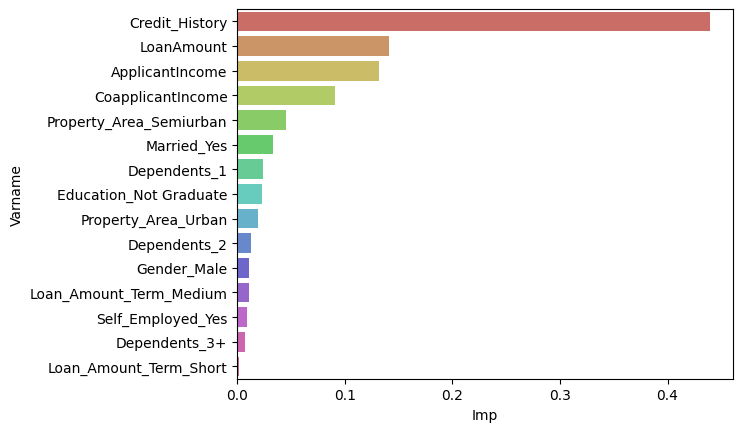

In [18]:
#Random forest feature importance
#rfe_features = loan_test_df.columns[rf_model[-2].support_]

imp_df = pd.DataFrame({
    "Varname": feature_names,
    "Imp": rf_model[-1].feature_importances_
})
sorted_imp = imp_df.sort_values('Imp', ascending=False)
sns.barplot(y=sorted_imp["Varname"], x=sorted_imp["Imp"], palette='hls')

## Classification model interpretation

In [19]:
explainer = shap.TreeExplainer(model= rf_model.named_steps['randomforestclassifier'])
#overall_shap = explainer(loan_test_df)
shap_values = explainer.shap_values(loan_test_df)
#shap_values = explainer.shap_values(loan_test_preprocessed)


In [26]:
shap_values.shape

(367, 15, 2)

In [20]:
print(shap_values[:,:,0].shape)
print(loan_test_df.shape)

(367, 15)
(367, 15)


In [158]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [159]:
print_feature_importances_shap_values(overall_shap, loan_test_df.columns)

Credit_History -> 0.1297 (softmax = 0.0744)
Property_Area_Semiurban -> 0.0304 (softmax = 0.0674)
LoanAmount -> 0.0228 (softmax = 0.0669)
Education_Not Graduate -> 0.0194 (softmax = 0.0666)
Married_Yes -> 0.0188 (softmax = 0.0666)
Dependents_1 -> 0.0186 (softmax = 0.0666)
CoapplicantIncome -> 0.0162 (softmax = 0.0664)
ApplicantIncome -> 0.0108 (softmax = 0.0661)
Property_Area_Urban -> 0.0068 (softmax = 0.0658)
Dependents_2 -> 0.0045 (softmax = 0.0657)
Dependents_3+ -> 0.0026 (softmax = 0.0655)
Gender_Male -> 0.0024 (softmax = 0.0655)
Loan_Amount_Term_Medium -> 0.0022 (softmax = 0.0655)
Self_Employed_Yes -> 0.0021 (softmax = 0.0655)
Loan_Amount_Term_Short -> 0.0002 (softmax = 0.0654)


In [ ]:
#global effect
#bar
#beeswarm
#violin
#dot

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_32840\3940853619.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], loan_test_df, feature_names, plot_type='bar')


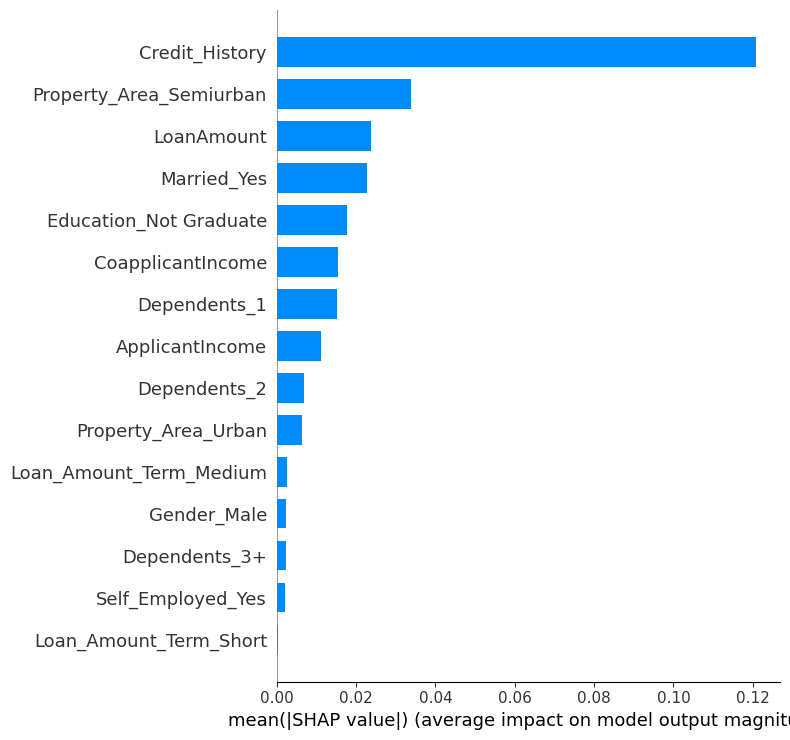

In [212]:
#summary plot
shap.summary_plot(shap_values[:,:,1], loan_test_df, feature_names, plot_type='bar')

'''
Graph shows the feature importance of each feature in the model. ordered from highest to lowest
'''

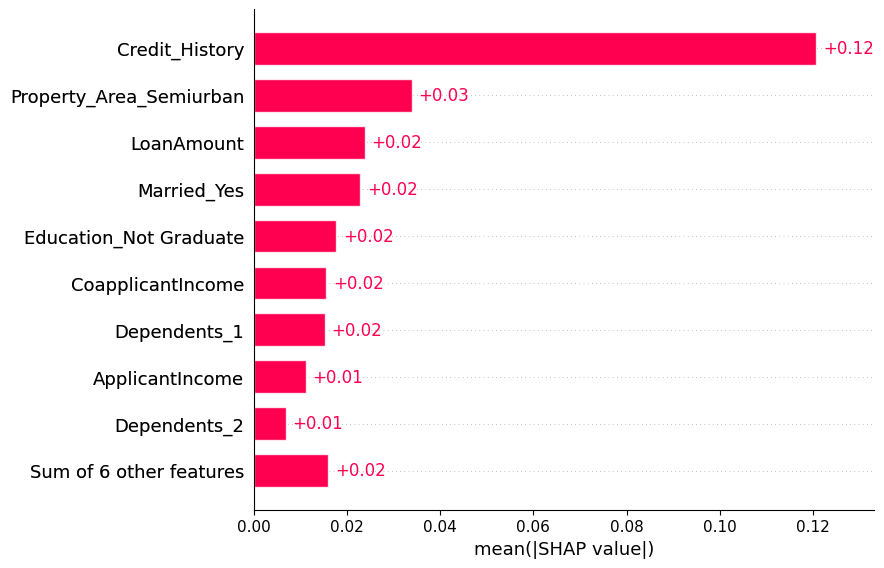

In [245]:
#bar
shap_exp = shap.Explanation(values=shap_values[:, :, 1], base_values=explainer.expected_value[1], data=loan_test_df, feature_names=feature_names)
shap.plots.bar(shap_exp)

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_32840\1456888185.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], feature_names, plot_type='violin')


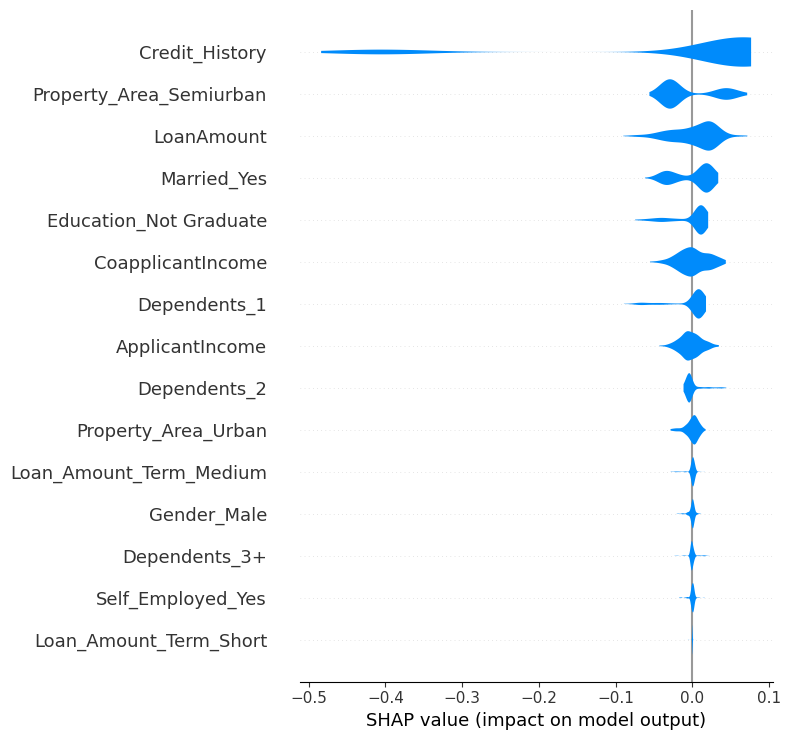

In [211]:
shap.summary_plot(shap_values[:,:,1], feature_names, plot_type='violin')

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_32840\1869345269.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1], loan_test_df, plot_type="dot")


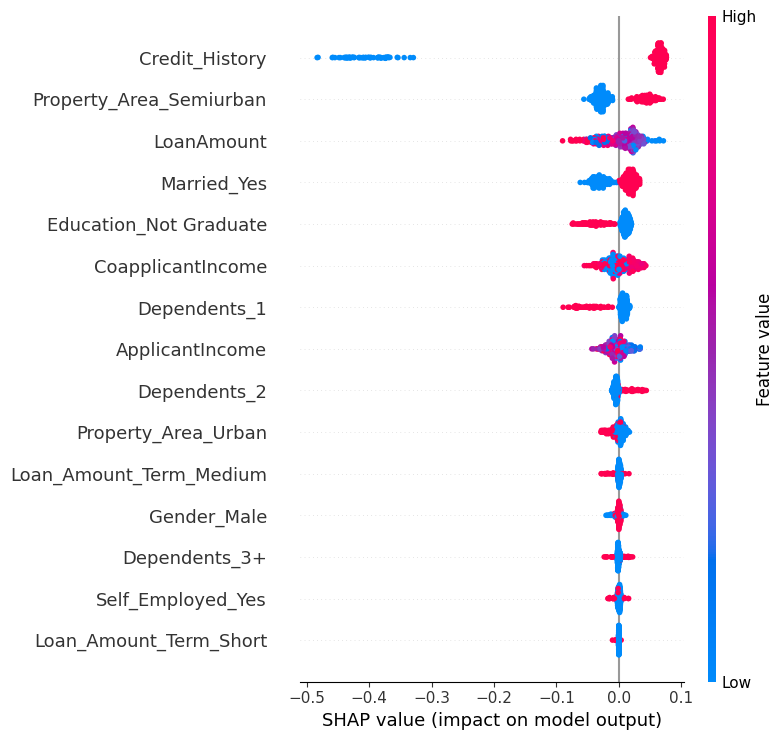

'\nInterpretation:\nFor class 1 (Loan approval - Yes) prediction, if credit history is high (1.0) then it positively affects the shap values. Meaning for good credit\nhistory we get positvely driven prediction. Conversely low credit history (0.0) shows negative shap values. i.e predicting towards "No" class\n'

In [232]:
shap.summary_plot(shap_values[:,:,1], loan_test_df, plot_type="dot")

'''
Interpretation:
For class 1 (Loan approval - Yes) prediction, if credit history is high (1.0) then it positively affects the shap values. Meaning for good credit
history we get positvely driven prediction. Conversely low credit history (0.0) shows negative shap values. i.e predicting towards "No" class
'''

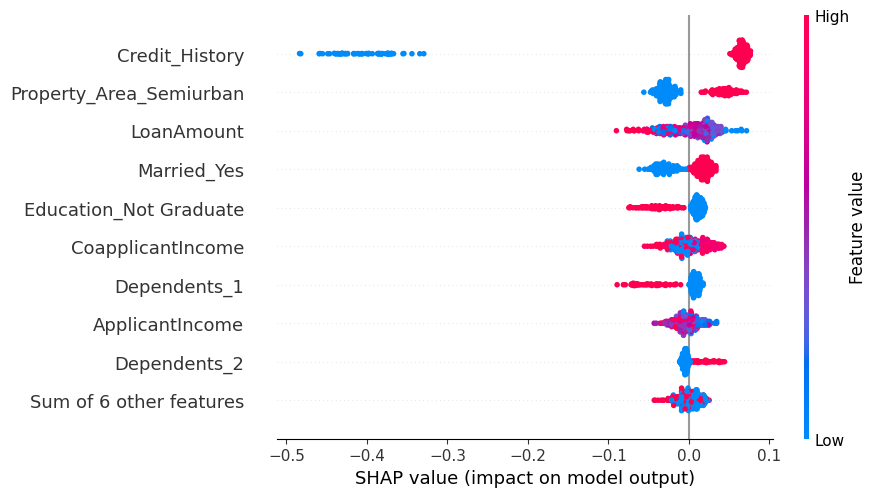

In [231]:
shap_exp = shap.Explanation(values=shap_values[:, :, 1], base_values=explainer.expected_value[1], data=loan_test_df)
shap.plots.beeswarm(shap_exp)

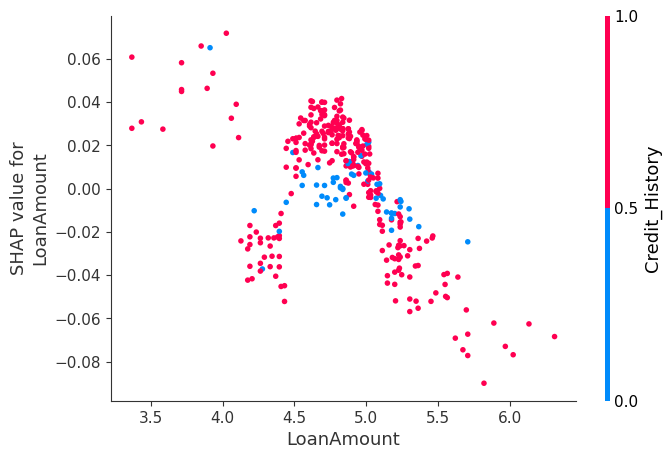

In [234]:
#Specific feature interpretation
shap.dependence_plot("LoanAmount", shap_values[:,:,1], loan_test_df, interaction_index="Credit_History")

In [ ]:
#local interpretation
#bar
#waterfall
#force
#decision

In [253]:
shap_exp = shap.Explanation(values=shap_values[:, :, 1], base_values=explainer.expected_value[1], data=loan_test_df, feature_names=feature_names)
shap_exp[0]

.values =
array([ 0.0008327 ,  0.00676338,  0.02006633,  0.00203076,  0.02084577,
        0.00580934, -0.00180658, -0.00151788,  0.01341031,  0.00101948,
        0.0006917 ,  0.0004244 , -0.0281329 , -0.00078336,  0.07404739])

.base_values =
0.6855804480651728

.data =
ApplicantIncome            8.651899
CoapplicantIncome          0.000000
LoanAmount                 4.709530
Gender_Male                1.000000
Married_Yes                1.000000
Dependents_1               0.000000
Dependents_2               0.000000
Dependents_3+              0.000000
Education_Not Graduate     0.000000
Self_Employed_Yes          0.000000
Loan_Amount_Term_Medium    0.000000
Loan_Amount_Term_Short     0.000000
Property_Area_Semiurban    0.000000
Property_Area_Urban        1.000000
Credit_History             1.000000
Name: 0, dtype: float64

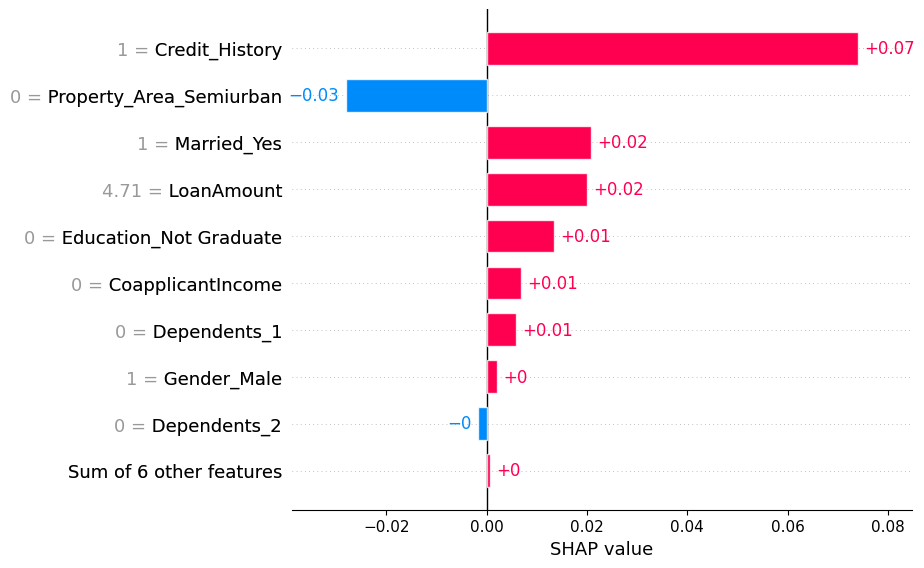

'\nThis plot shows us what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.\nHere, credit_history, married postively affects the prediction for Loan Approval - Yes. \nProperty Area - Semiurban negatively affects the prediction. \n'

In [295]:
shap.plots.bar(shap_exp[0])

'''
This plot shows us what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature.
Here, credit_history, married postively affects the prediction for Loan Approval - Yes. 
Property Area - Semiurban negatively affects the prediction. 
'''

Probability of Yes - [0.79928129]


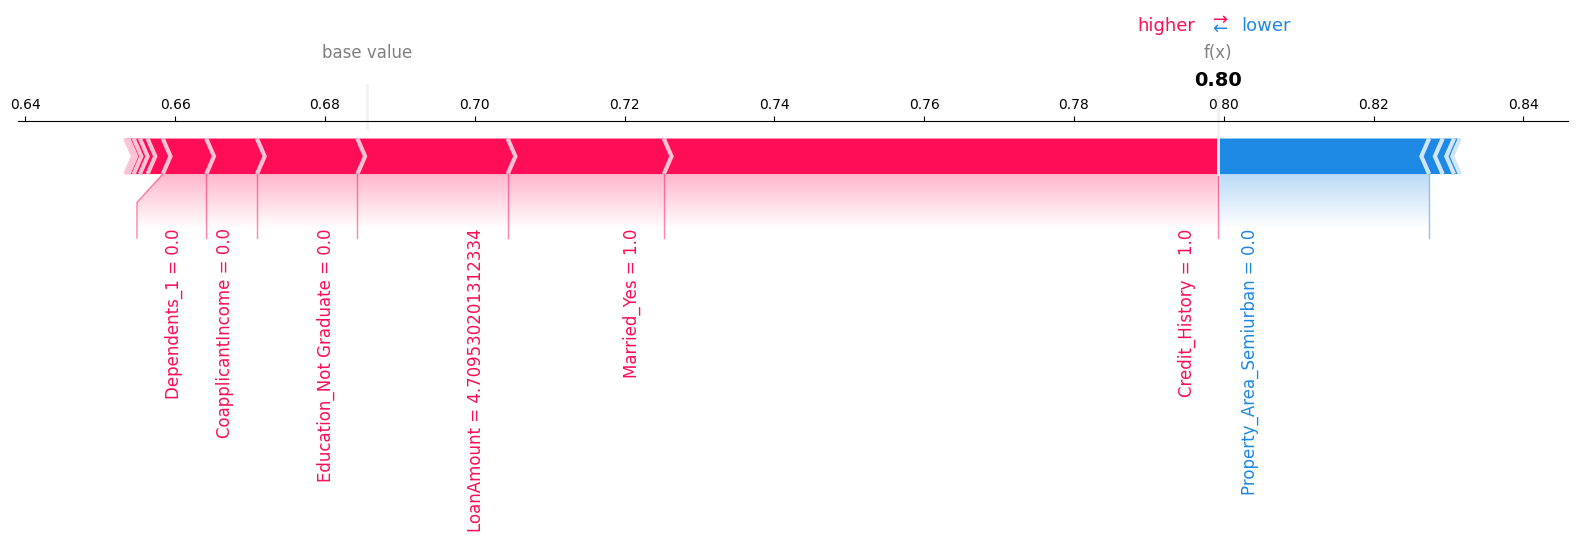

In [322]:
prob_1 = rf_model[-1].predict_proba(np.array(loan_test_df.iloc[0,:]).reshape(1,-1))
print(f'Probability of Yes - {prob_1[:,1]}')

#force plot
shap.plots.force(explainer.expected_value[1], shap_values[0][:,1], loan_test_df.iloc[0, :], matplotlib = True, text_rotation='vertical')

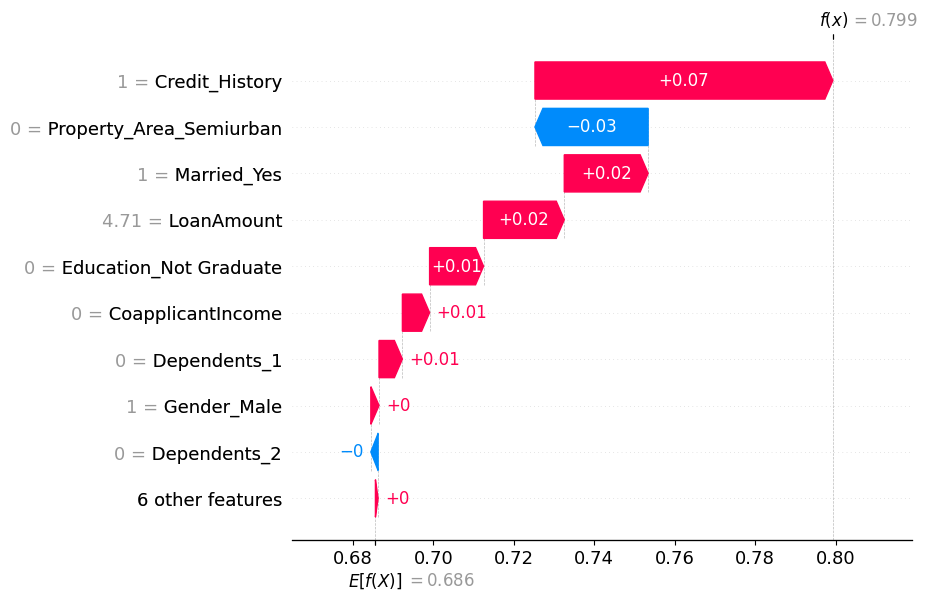

In [325]:
#waterfall plot
shap.plots.waterfall(shap_exp[0])

'''
Here we can see how the sum of all the SHAP values equals the difference between the prediction f(x) and the expected value E[f(x)].
(0.14 - 0.03) = 0.11  #sum of shap values
(0-79 - 0.66) = 0.11  #f(x) - E[f(x)]
'''

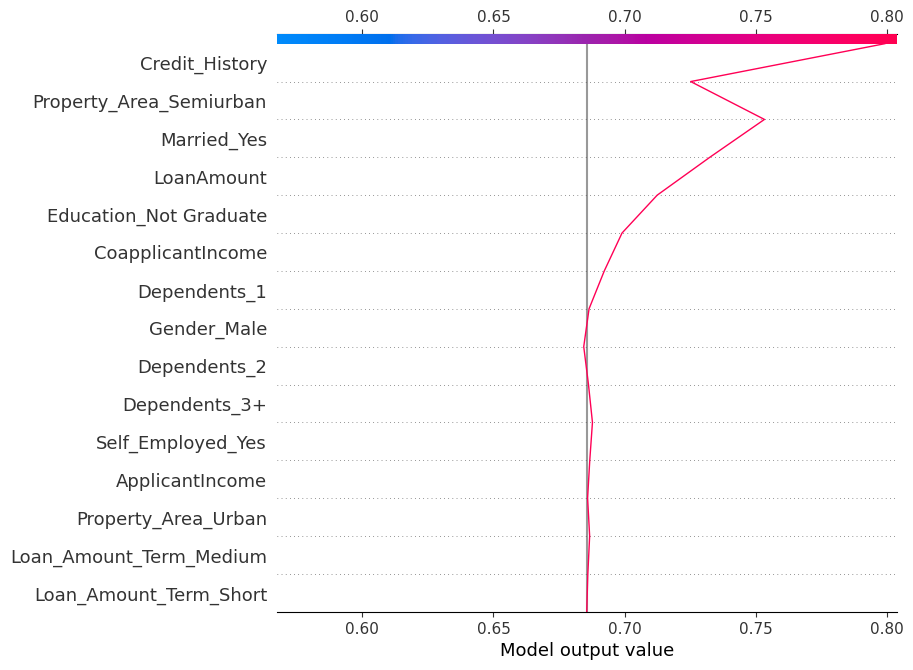

['Y']


In [31]:
#decision plot
shap.decision_plot(explainer.expected_value[1], shap_values[0][:,1], loan_test_df.columns)

prediction = rf_model[-1].predict(np.array(loan_test_df.iloc[0,:]).reshape(1,-1))
print(prediction)

['N']


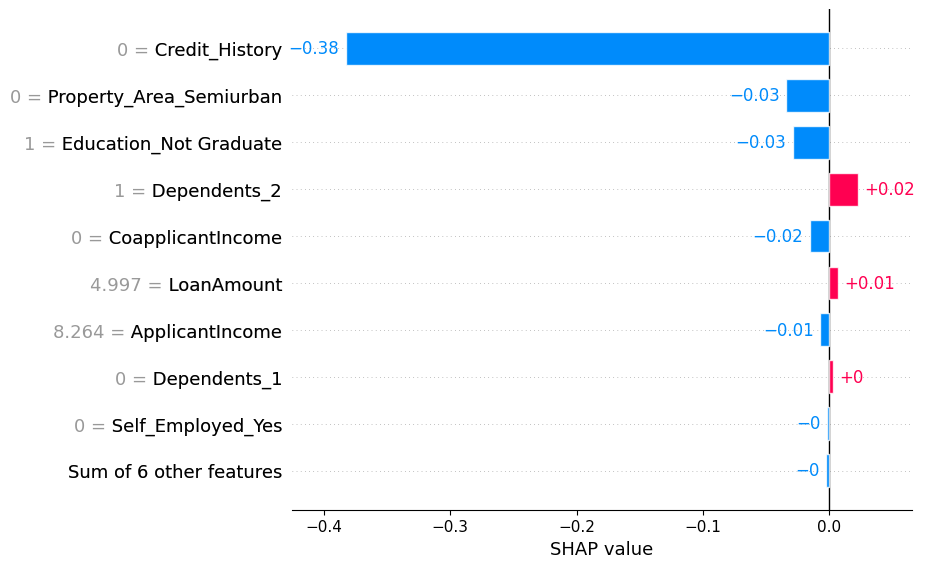

'\nTo check the visuals for negative class we have taken a data row that predictis Loan approval - No (negative). \nHere, credit history is 0 and it dragged the prediction to No.\n'

In [306]:
prediction = rf_model[-1].predict(np.array(loan_test_df.iloc[7,:]).reshape(1,-1))
print(prediction)
shap.plots.bar(shap_exp[7])

'''
To check the visuals for negative class we have taken a data row that predictis Loan approval - No (negative). 
Here, credit history is 0 and it dragged the prediction to No.
'''

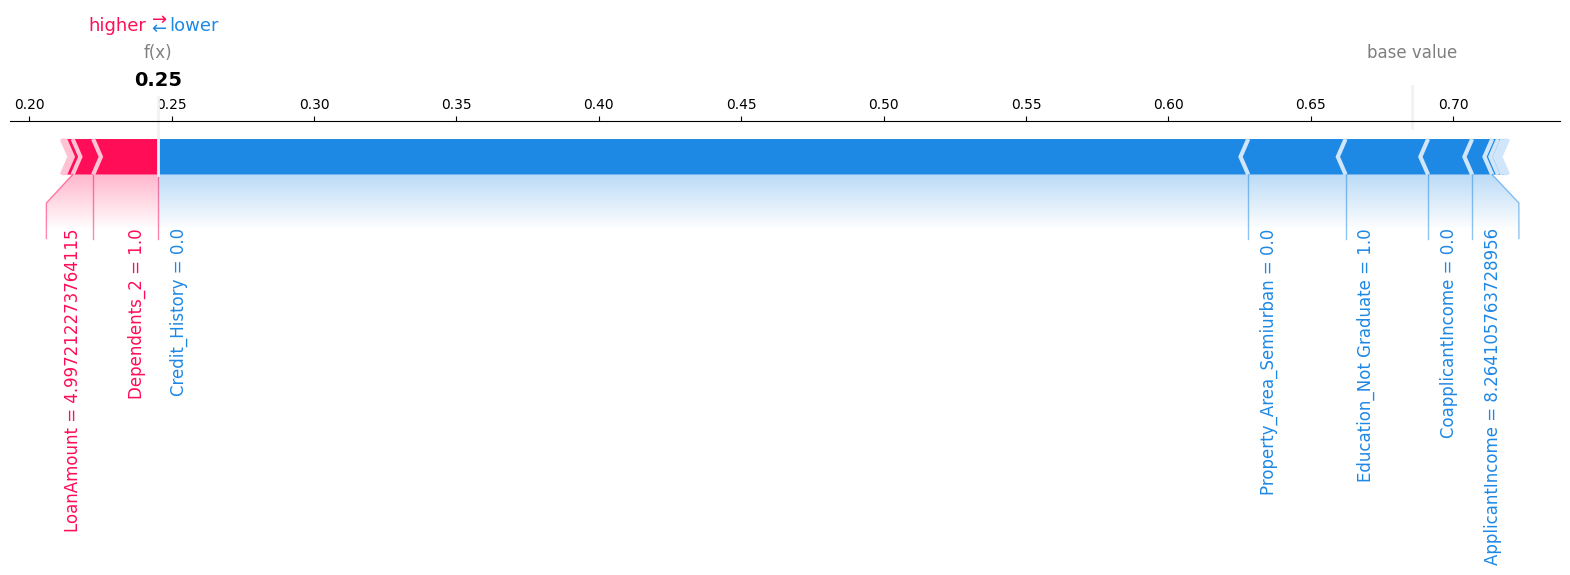

In [307]:
shap.plots.force(explainer.expected_value[1], shap_values[7][:,1], loan_test_df.iloc[7, :], matplotlib = True, text_rotation='vertical')

In [333]:
'''
If the model has higher SHAP contributions for one group, it may be favoring or penalizing that group.
A large difference in mean SHAP values across groups indicate bias
'''
group_1 = shap_values[loan_test_df["Credit_History"] == 1].mean(axis=1)
group_2 = shap_values[loan_test_df["Credit_History"] == 0].mean(axis=1)

print("Mean SHAP for Male:", np.mean(group_1))
print("Mean SHAP for Female:", np.mean(group_2))

Mean SHAP for Male: -1.0137994340124197e-19
Mean SHAP for Female: -2.8814050956902898e-18


## Regression Model Interpretation

In [128]:
import shap
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# California Housing Prices
dataset = fetch_california_housing(as_frame = True)
X = dataset['data']
y = dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()
# Fits the model on the data
model.fit(X_train, y_train)

RandomForestRegressor()

In [130]:
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

ExactExplainer explainer: 4129it [19:41,  3.47it/s]                                                                                              


In [133]:
print_feature_importances_shap_values(shap_values, X_train.columns)

MedInc -> 0.4940 (softmax = 0.1670)
Latitude -> 0.3681 (softmax = 0.1472)
Longitude -> 0.2778 (softmax = 0.1345)
AveOccup -> 0.2055 (softmax = 0.1251)
HouseAge -> 0.0750 (softmax = 0.1098)
AveRooms -> 0.0537 (softmax = 0.1075)
AveBedrms -> 0.0278 (softmax = 0.1048)
Population -> 0.0207 (softmax = 0.1040)


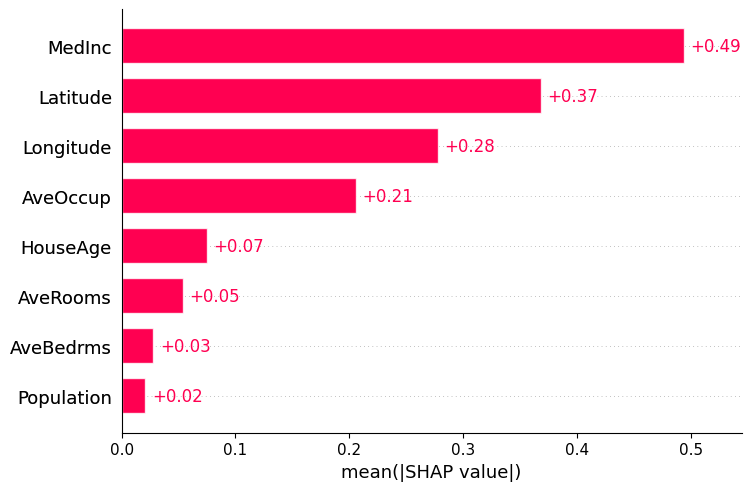

In [134]:
shap.plots.bar(shap_values)

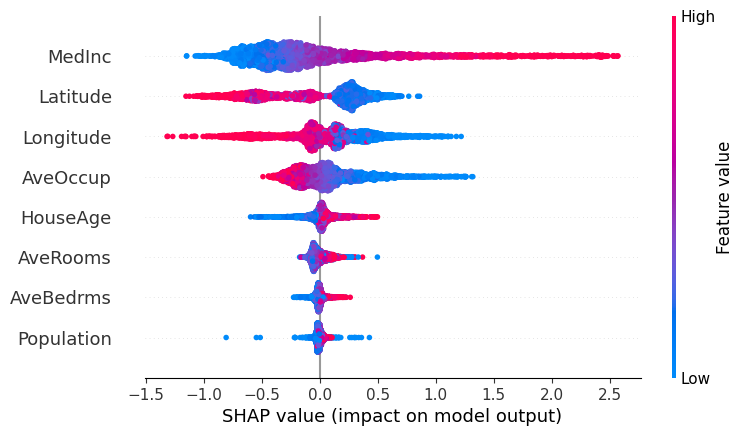

In [135]:
shap.plots.beeswarm(shap_values)

C:\Users\EdwinVivekN\AppData\Local\Temp\ipykernel_32840\4117389138.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, plot_type='violin')


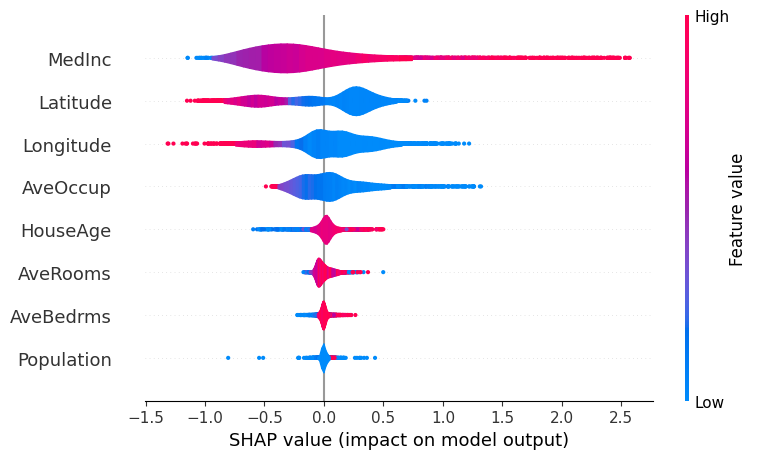

In [136]:
shap.summary_plot(shap_values, plot_type='violin')

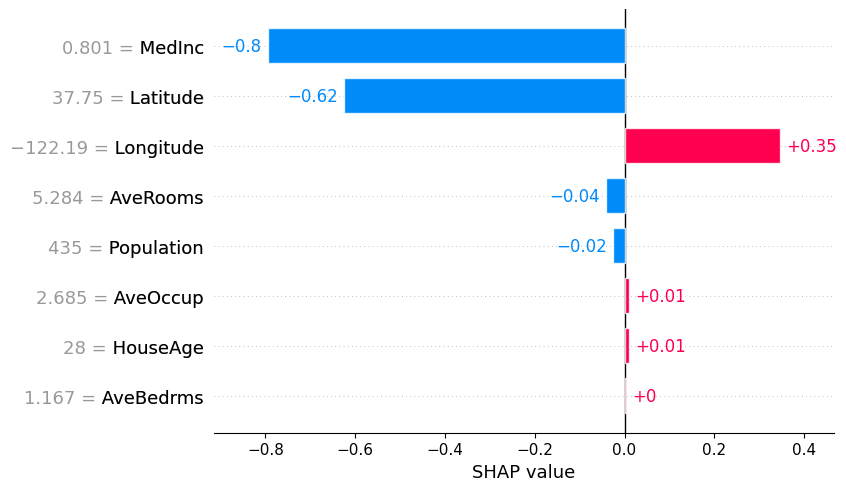

In [137]:
shap.plots.bar(shap_values[0])

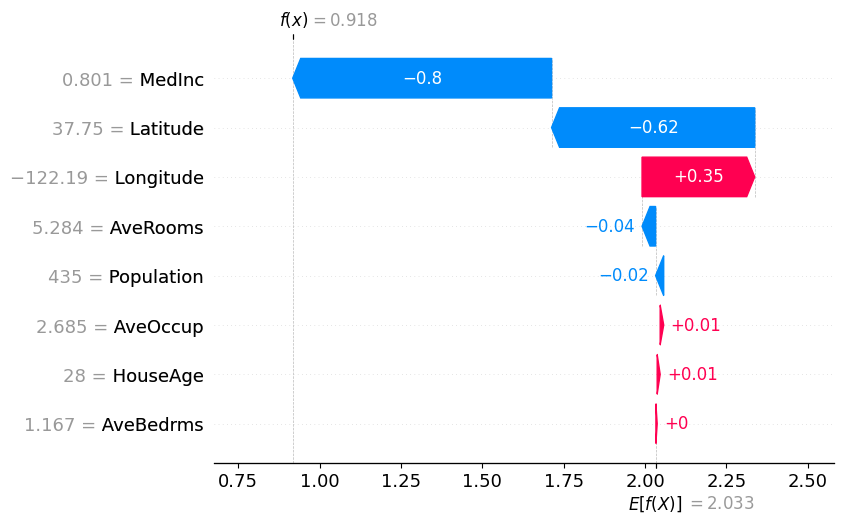

In [138]:
shap.plots.waterfall(shap_values[0])

In [140]:
shap.plots.force(shap_values[0])

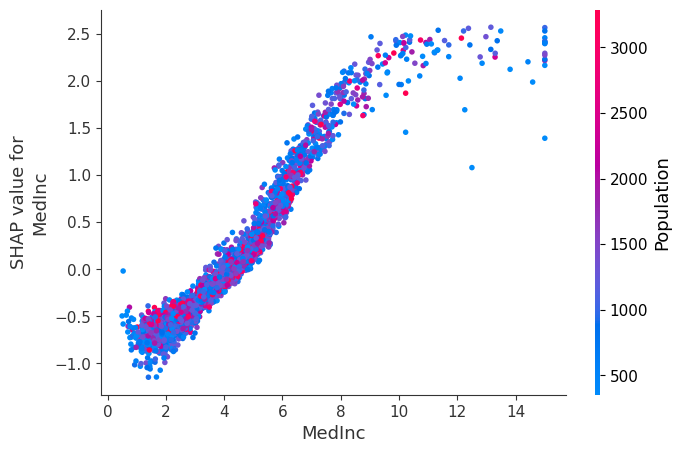

In [153]:
shap.dependence_plot("MedInc", shap_values.values, X_test, interaction_index="Population")

In [154]:
X_test["MedInc"]

320      0.8012
17098    7.1088
13769    4.2333
13502    2.4444
7560     2.8793
          ...  
19897    1.5464
14959    5.1221
19627    2.2566
3468     3.0000
18411    4.8862
Name: MedInc, Length: 4128, dtype: float64